In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tqdm
import numpy
import torch
import torchvision
import torchvision.transforms.v2

transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True)
])

train = torchvision.datasets.CIFAR10('cifar-10', transform = transform, train = True, download = False)
test = torchvision.datasets.CIFAR10('cifar-10', transform = transform, train = False, download = False)

train_images = numpy.array([ numpy.array(item[0]).transpose((1, 2, 0)) for item in tqdm.tqdm(train) ])
train_labels = numpy.array([ item[1] for item in train ])

test_images = numpy.array([ numpy.array(item[0]).transpose((1, 2, 0)) for item in tqdm.tqdm(test) ])
test_labels = numpy.array([ item[1] for item in test ])

train_images.shape, test_images.shape

100%|██████████| 10000/10000 [00:01<00:00, 9117.30it/s]


((50000, 32, 32, 3), (10000, 32, 32, 3))

100%|██████████| 10000/10000 [00:00<00:00, 66934.51it/s]


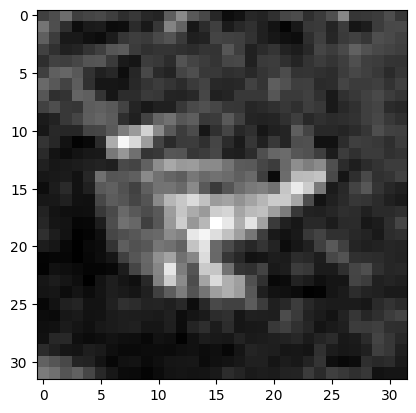

In [3]:
import skimage.color

train_images = numpy.array([ skimage.color.rgb2gray(item) for item in tqdm.tqdm(train_images) ])
test_images = numpy.array([ skimage.color.rgb2gray(item) for item in tqdm.tqdm(test_images) ])

import matplotlib.pyplot as plt

plt.imshow(train_images[22], cmap = "gray")

In [4]:
import os
import cvtda.topology

def make_features(train, test, binarizer, filtration):
    if binarizer is not None:
        train = binarizer.fit_transform(train)
        test = binarizer.transform(test)
        
    if filtration is not None:
        train = filtration.fit_transform(train)
        test = filtration.transform(test)

    filtrations_to_diagrams = cvtda.topology.FiltrationsToDiagrams(homology_dimensions = [ 0, 1 ], verbose = False)
    train = filtrations_to_diagrams.fit_transform(train)
    test = filtrations_to_diagrams.transform(test)
    print(train.shape, test.shape)

    if len(train[0]) < 96:
        n_bins = 32
    elif len(train[0]) < 192:
        n_bins = 64
    else:
        n_bins = 128

    print(f"Bins: {n_bins}")
    digrams_to_features = cvtda.topology.DiagramsToFeatures(batch_size = 625, n_bins = n_bins, verbose = False)
    train = digrams_to_features.fit_transform(train)
    test = digrams_to_features.transform(test)
    print(train.shape, test.shape)
    return train, test

In [5]:
import itertools

import gtda.images

def process(train: numpy.ndarray, test: numpy.ndarray):
    train_features = [ ]
    test_features = [ ]
    tr, te = make_features(train, test, binarizer = None, filtration = None)
    train_features.append(tr)
    test_features.append(te)

    if train.shape[-1] == 32:
        centers = [ 5, 12, 18, 25 ]
    else:
        centers = [ 5, 10 ]
    print(centers)

    greyscale_to_filtrations = cvtda.topology.GreyscaleToFiltrations(
        binarizer_threshold = 0.4,
        radial_filtration_centers = list(itertools.product(centers, centers))
    )
    for i, filtration in enumerate(greyscale_to_filtrations.filtrations_):
        print(f"{i}/{len(greyscale_to_filtrations.filtrations_)}). {filtration}")
        tr, te = make_features(
            train,
            test,
            binarizer = gtda.images.Binarizer(threshold = 0.4),
            filtration = filtration
        )
        train_features.append(tr)
        test_features.append(te)
    return numpy.hstack(train_features), numpy.hstack(test_features)

In [6]:
def split_image(image: numpy.ndarray) -> numpy.ndarray:
    splits = [ ]
    for start_x in range(0, 17, 8):
        for start_y in range(0, 17, 8):
            splits.append(image[start_x:start_x + 16, start_y:start_y + 16])
    return numpy.array(splits)

train_image_parts = numpy.array([ split_image(item) for item in tqdm.tqdm(train_images) ]).transpose((1, 0, 2, 3))
test_image_parts = numpy.array([ split_image(item) for item in tqdm.tqdm(test_images) ]).transpose((1, 0, 2, 3))

train_image_parts.shape, test_image_parts.shape

100%|██████████| 10000/10000 [00:00<00:00, 95135.04it/s]


((9, 50000, 16, 16), (9, 10000, 16, 16))

In [7]:
for i, (train, test) in enumerate(zip(train_image_parts, test_image_parts)):
    tr, te = process(train, test)
    print(tr.shape, te.shape)
    numpy.save(f"10/{i}_train.npy", tr)
    numpy.save(f"10/{i}_test.npy", te)

100%|██████████| 10000/10000 [00:00<00:00, 31471.31it/s]


(50000, 72, 3) (10000, 65, 3)
Bins: 32


d:\Programs\Programming\Python\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


(50000, 70) (10000, 70)
[5, 10]
0/12). HeightFiltration(direction=array([-1, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 26923.96it/s]


(50000, 33, 3) (10000, 26, 3)
Bins: 32
(50000, 70) (10000, 70)
1/12). HeightFiltration(direction=array([1, 1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 26526.25it/s]


(50000, 34, 3) (10000, 28, 3)
Bins: 32
(50000, 70) (10000, 70)
2/12). HeightFiltration(direction=array([ 1, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 20267.48it/s]


(50000, 34, 3) (10000, 27, 3)
Bins: 32
(50000, 70) (10000, 70)
3/12). HeightFiltration(direction=array([-1,  1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 30585.26it/s]


(50000, 34, 3) (10000, 28, 3)
Bins: 32
(50000, 70) (10000, 70)
4/12). HeightFiltration(direction=array([ 0, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 24999.96it/s]


(50000, 33, 3) (10000, 26, 3)
Bins: 32
(50000, 70) (10000, 70)
5/12). HeightFiltration(direction=array([0, 1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 26246.80it/s]


(50000, 32, 3) (10000, 28, 3)
Bins: 32
(50000, 70) (10000, 70)
6/12). HeightFiltration(direction=array([-1,  0]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 22675.79it/s]


(50000, 33, 3) (10000, 26, 3)
Bins: 32
(50000, 70) (10000, 70)
7/12). HeightFiltration(direction=array([1, 0]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 24813.84it/s]


(50000, 33, 3) (10000, 27, 3)
Bins: 32
(50000, 70) (10000, 70)
8/12). RadialFiltration(center=array([5, 5]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 29675.85it/s]


(50000, 33, 3) (10000, 28, 3)
Bins: 32
(50000, 70) (10000, 70)
9/12). RadialFiltration(center=array([ 5, 10]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 31446.65it/s]


(50000, 34, 3) (10000, 27, 3)
Bins: 32
(50000, 70) (10000, 70)
10/12). RadialFiltration(center=array([10,  5]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 31152.78it/s]


(50000, 35, 3) (10000, 28, 3)
Bins: 32
(50000, 70) (10000, 70)
11/12). RadialFiltration(center=array([10, 10]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 31156.04it/s]


(50000, 33, 3) (10000, 29, 3)
Bins: 32
(50000, 70) (10000, 70)
(50000, 910) (10000, 910)


100%|██████████| 10000/10000 [00:00<00:00, 34607.58it/s]


(50000, 68, 3) (10000, 67, 3)
Bins: 32
(50000, 70) (10000, 70)
[5, 10]
0/12). HeightFiltration(direction=array([-1, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 28328.50it/s]


(50000, 32, 3) (10000, 33, 3)
Bins: 32
(50000, 70) (10000, 70)
1/12). HeightFiltration(direction=array([1, 1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 28985.44it/s]


(50000, 32, 3) (10000, 31, 3)
Bins: 32
(50000, 70) (10000, 70)
2/12). HeightFiltration(direction=array([ 1, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 27855.10it/s]


(50000, 30, 3) (10000, 31, 3)
Bins: 32
(50000, 70) (10000, 70)
3/12). HeightFiltration(direction=array([-1,  1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 24038.47it/s]


(50000, 32, 3) (10000, 31, 3)
Bins: 32
(50000, 70) (10000, 70)
4/12). HeightFiltration(direction=array([ 0, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 29239.44it/s]


(50000, 32, 3) (10000, 31, 3)
Bins: 32
(50000, 70) (10000, 70)
5/12). HeightFiltration(direction=array([0, 1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 27933.03it/s]


(50000, 31, 3) (10000, 31, 3)
Bins: 32
(50000, 70) (10000, 70)
6/12). HeightFiltration(direction=array([-1,  0]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 28437.12it/s]


(50000, 32, 3) (10000, 31, 3)
Bins: 32
(50000, 70) (10000, 70)
7/12). HeightFiltration(direction=array([1, 0]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 29411.81it/s]


(50000, 30, 3) (10000, 31, 3)
Bins: 32
(50000, 70) (10000, 70)
8/12). RadialFiltration(center=array([5, 5]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 25252.62it/s]


(50000, 32, 3) (10000, 31, 3)
Bins: 32
(50000, 70) (10000, 70)
9/12). RadialFiltration(center=array([ 5, 10]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 26809.62it/s]


(50000, 32, 3) (10000, 31, 3)
Bins: 32
(50000, 70) (10000, 70)
10/12). RadialFiltration(center=array([10,  5]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 28901.24it/s]


(50000, 32, 3) (10000, 31, 3)
Bins: 32
(50000, 70) (10000, 70)
11/12). RadialFiltration(center=array([10, 10]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 28934.24it/s]


(50000, 33, 3) (10000, 32, 3)
Bins: 32
(50000, 70) (10000, 70)
(50000, 910) (10000, 910)


100%|██████████| 10000/10000 [00:00<00:00, 23823.11it/s]


(50000, 71, 3) (10000, 70, 3)
Bins: 32
(50000, 70) (10000, 70)
[5, 10]
0/12). HeightFiltration(direction=array([-1, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 24488.07it/s]


(50000, 31, 3) (10000, 34, 3)
Bins: 32
(50000, 70) (10000, 70)
1/12). HeightFiltration(direction=array([1, 1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 27510.85it/s]


(50000, 31, 3) (10000, 33, 3)
Bins: 32
(50000, 70) (10000, 70)
2/12). HeightFiltration(direction=array([ 1, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 27174.19it/s]


(50000, 31, 3) (10000, 33, 3)
Bins: 32
(50000, 70) (10000, 70)
3/12). HeightFiltration(direction=array([-1,  1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 27986.80it/s]


(50000, 31, 3) (10000, 34, 3)
Bins: 32
(50000, 70) (10000, 70)
4/12). HeightFiltration(direction=array([ 0, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 27773.94it/s]


(50000, 31, 3) (10000, 32, 3)
Bins: 32
(50000, 70) (10000, 70)
5/12). HeightFiltration(direction=array([0, 1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 24937.82it/s]


(50000, 31, 3) (10000, 34, 3)
Bins: 32
(50000, 70) (10000, 70)
6/12). HeightFiltration(direction=array([-1,  0]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 19207.50it/s]


(50000, 31, 3) (10000, 32, 3)
Bins: 32
(50000, 70) (10000, 70)
7/12). HeightFiltration(direction=array([1, 0]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 28902.32it/s]


(50000, 31, 3) (10000, 32, 3)
Bins: 32
(50000, 70) (10000, 70)
8/12). RadialFiltration(center=array([5, 5]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 29242.31it/s]


(50000, 33, 3) (10000, 35, 3)
Bins: 32
(50000, 70) (10000, 70)
9/12). RadialFiltration(center=array([ 5, 10]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 22626.79it/s]


(50000, 32, 3) (10000, 35, 3)
Bins: 32
(50000, 70) (10000, 70)
10/12). RadialFiltration(center=array([10,  5]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 30868.09it/s]


(50000, 34, 3) (10000, 34, 3)
Bins: 32
(50000, 70) (10000, 70)
11/12). RadialFiltration(center=array([10, 10]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 29943.42it/s]


(50000, 32, 3) (10000, 34, 3)
Bins: 32
(50000, 70) (10000, 70)
(50000, 910) (10000, 910)


100%|██████████| 10000/10000 [00:00<00:00, 33008.34it/s]


(50000, 71, 3) (10000, 63, 3)
Bins: 32
(50000, 70) (10000, 70)
[5, 10]
0/12). HeightFiltration(direction=array([-1, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 28090.06it/s]


(50000, 33, 3) (10000, 28, 3)
Bins: 32
(50000, 70) (10000, 70)
1/12). HeightFiltration(direction=array([1, 1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 21459.22it/s]


(50000, 31, 3) (10000, 29, 3)
Bins: 32
(50000, 70) (10000, 70)
2/12). HeightFiltration(direction=array([ 1, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 29673.58it/s]


(50000, 31, 3) (10000, 29, 3)
Bins: 32
(50000, 70) (10000, 70)
3/12). HeightFiltration(direction=array([-1,  1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 29676.81it/s]


(50000, 30, 3) (10000, 29, 3)
Bins: 32
(50000, 70) (10000, 70)
4/12). HeightFiltration(direction=array([ 0, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 26595.82it/s]


(50000, 33, 3) (10000, 28, 3)
Bins: 32
(50000, 70) (10000, 70)
5/12). HeightFiltration(direction=array([0, 1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 28248.54it/s]


(50000, 30, 3) (10000, 29, 3)
Bins: 32
(50000, 70) (10000, 70)
6/12). HeightFiltration(direction=array([-1,  0]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 25039.25it/s]


(50000, 29, 3) (10000, 28, 3)
Bins: 32
(50000, 70) (10000, 70)
7/12). HeightFiltration(direction=array([1, 0]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 28173.31it/s]


(50000, 33, 3) (10000, 30, 3)
Bins: 32
(50000, 70) (10000, 70)
8/12). RadialFiltration(center=array([5, 5]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 29157.24it/s]


(50000, 32, 3) (10000, 29, 3)
Bins: 32
(50000, 70) (10000, 70)
9/12). RadialFiltration(center=array([ 5, 10]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 26246.65it/s]


(50000, 32, 3) (10000, 29, 3)
Bins: 32
(50000, 70) (10000, 70)
10/12). RadialFiltration(center=array([10,  5]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 26387.39it/s]


(50000, 32, 3) (10000, 30, 3)
Bins: 32
(50000, 70) (10000, 70)
11/12). RadialFiltration(center=array([10, 10]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 21788.82it/s]


(50000, 31, 3) (10000, 29, 3)
Bins: 32
(50000, 70) (10000, 70)
(50000, 910) (10000, 910)


100%|██████████| 10000/10000 [00:00<00:00, 23755.00it/s]


(50000, 70, 3) (10000, 66, 3)
Bins: 32
(50000, 70) (10000, 70)
[5, 10]
0/12). HeightFiltration(direction=array([-1, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 29154.06it/s]


(50000, 31, 3) (10000, 27, 3)
Bins: 32
(50000, 70) (10000, 70)
1/12). HeightFiltration(direction=array([1, 1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 25252.49it/s]


(50000, 31, 3) (10000, 26, 3)
Bins: 32
(50000, 70) (10000, 70)
2/12). HeightFiltration(direction=array([ 1, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 27137.74it/s]


(50000, 32, 3) (10000, 26, 3)
Bins: 32
(50000, 70) (10000, 70)
3/12). HeightFiltration(direction=array([-1,  1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 28490.04it/s]


(50000, 32, 3) (10000, 26, 3)
Bins: 32
(50000, 70) (10000, 70)
4/12). HeightFiltration(direction=array([ 0, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 23041.50it/s]


(50000, 31, 3) (10000, 27, 3)
Bins: 32
(50000, 70) (10000, 70)
5/12). HeightFiltration(direction=array([0, 1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 28571.26it/s]


(50000, 30, 3) (10000, 26, 3)
Bins: 32
(50000, 70) (10000, 70)
6/12). HeightFiltration(direction=array([-1,  0]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 28408.57it/s]


(50000, 31, 3) (10000, 26, 3)
Bins: 32
(50000, 70) (10000, 70)
7/12). HeightFiltration(direction=array([1, 0]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 28653.34it/s]


(50000, 31, 3) (10000, 25, 3)
Bins: 32
(50000, 70) (10000, 70)
8/12). RadialFiltration(center=array([5, 5]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 30029.33it/s]


(50000, 32, 3) (10000, 27, 3)
Bins: 32
(50000, 70) (10000, 70)
9/12). RadialFiltration(center=array([ 5, 10]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 25062.66it/s]


(50000, 32, 3) (10000, 28, 3)
Bins: 32
(50000, 70) (10000, 70)
10/12). RadialFiltration(center=array([10,  5]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 30307.20it/s]


(50000, 33, 3) (10000, 27, 3)
Bins: 32
(50000, 70) (10000, 70)
11/12). RadialFiltration(center=array([10, 10]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 29502.32it/s]


(50000, 33, 3) (10000, 27, 3)
Bins: 32
(50000, 70) (10000, 70)
(50000, 910) (10000, 910)


100%|██████████| 10000/10000 [00:00<00:00, 36231.63it/s]


(50000, 66, 3) (10000, 69, 3)
Bins: 32
(50000, 70) (10000, 70)
[5, 10]
0/12). HeightFiltration(direction=array([-1, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 29761.93it/s]


(50000, 33, 3) (10000, 26, 3)
Bins: 32
(50000, 70) (10000, 70)
1/12). HeightFiltration(direction=array([1, 1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 30868.18it/s]


(50000, 32, 3) (10000, 26, 3)
Bins: 32
(50000, 70) (10000, 70)
2/12). HeightFiltration(direction=array([ 1, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 28409.42it/s]


(50000, 31, 3) (10000, 27, 3)
Bins: 32
(50000, 70) (10000, 70)
3/12). HeightFiltration(direction=array([-1,  1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 27027.23it/s]


(50000, 33, 3) (10000, 26, 3)
Bins: 32
(50000, 70) (10000, 70)
4/12). HeightFiltration(direction=array([ 0, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 26628.46it/s]


(50000, 31, 3) (10000, 27, 3)
Bins: 32
(50000, 70) (10000, 70)
5/12). HeightFiltration(direction=array([0, 1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 26024.71it/s]


(50000, 31, 3) (10000, 25, 3)
Bins: 32
(50000, 70) (10000, 70)
6/12). HeightFiltration(direction=array([-1,  0]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 26526.15it/s]


(50000, 32, 3) (10000, 24, 3)
Bins: 32
(50000, 70) (10000, 70)
7/12). HeightFiltration(direction=array([1, 0]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 25354.64it/s]


(50000, 31, 3) (10000, 24, 3)
Bins: 32
(50000, 70) (10000, 70)
8/12). RadialFiltration(center=array([5, 5]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 24895.06it/s]


(50000, 32, 3) (10000, 27, 3)
Bins: 32
(50000, 70) (10000, 70)
9/12). RadialFiltration(center=array([ 5, 10]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 29693.66it/s]


(50000, 34, 3) (10000, 28, 3)
Bins: 32
(50000, 70) (10000, 70)
10/12). RadialFiltration(center=array([10,  5]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 22855.24it/s]


(50000, 31, 3) (10000, 27, 3)
Bins: 32
(50000, 70) (10000, 70)
11/12). RadialFiltration(center=array([10, 10]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 24691.30it/s]


(50000, 33, 3) (10000, 27, 3)
Bins: 32
(50000, 70) (10000, 70)
(50000, 910) (10000, 910)


100%|██████████| 10000/10000 [00:00<00:00, 32573.40it/s]


(50000, 78, 3) (10000, 62, 3)
Bins: 32
(50000, 70) (10000, 70)
[5, 10]
0/12). HeightFiltration(direction=array([-1, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 29073.02it/s]


(50000, 30, 3) (10000, 28, 3)
Bins: 32
(50000, 70) (10000, 70)
1/12). HeightFiltration(direction=array([1, 1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 26595.83it/s]


(50000, 31, 3) (10000, 28, 3)
Bins: 32
(50000, 70) (10000, 70)
2/12). HeightFiltration(direction=array([ 1, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 27548.23it/s]


(50000, 30, 3) (10000, 27, 3)
Bins: 32
(50000, 70) (10000, 70)
3/12). HeightFiltration(direction=array([-1,  1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 26044.15it/s]


(50000, 29, 3) (10000, 26, 3)
Bins: 32
(50000, 70) (10000, 70)
4/12). HeightFiltration(direction=array([ 0, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 28168.88it/s]


(50000, 31, 3) (10000, 28, 3)
Bins: 32
(50000, 70) (10000, 70)
5/12). HeightFiltration(direction=array([0, 1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 26595.73it/s]


(50000, 30, 3) (10000, 27, 3)
Bins: 32
(50000, 70) (10000, 70)
6/12). HeightFiltration(direction=array([-1,  0]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 27932.85it/s]


(50000, 29, 3) (10000, 28, 3)
Bins: 32
(50000, 70) (10000, 70)
7/12). HeightFiltration(direction=array([1, 0]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 23980.81it/s]


(50000, 30, 3) (10000, 28, 3)
Bins: 32
(50000, 70) (10000, 70)
8/12). RadialFiltration(center=array([5, 5]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 22584.61it/s]


(50000, 32, 3) (10000, 28, 3)
Bins: 32
(50000, 70) (10000, 70)
9/12). RadialFiltration(center=array([ 5, 10]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 27799.69it/s]


(50000, 32, 3) (10000, 28, 3)
Bins: 32
(50000, 70) (10000, 70)
10/12). RadialFiltration(center=array([10,  5]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 28328.62it/s]


(50000, 33, 3) (10000, 30, 3)
Bins: 32
(50000, 70) (10000, 70)
11/12). RadialFiltration(center=array([10, 10]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 27289.97it/s]


(50000, 32, 3) (10000, 29, 3)
Bins: 32
(50000, 70) (10000, 70)
(50000, 910) (10000, 910)


100%|██████████| 10000/10000 [00:00<00:00, 24190.60it/s]


(50000, 68, 3) (10000, 63, 3)
Bins: 32
(50000, 70) (10000, 70)
[5, 10]
0/12). HeightFiltration(direction=array([-1, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 26533.31it/s]


(50000, 32, 3) (10000, 25, 3)
Bins: 32
(50000, 70) (10000, 70)
1/12). HeightFiltration(direction=array([1, 1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 27543.89it/s]


(50000, 31, 3) (10000, 26, 3)
Bins: 32
(50000, 70) (10000, 70)
2/12). HeightFiltration(direction=array([ 1, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 28735.51it/s]


(50000, 30, 3) (10000, 26, 3)
Bins: 32
(50000, 70) (10000, 70)
3/12). HeightFiltration(direction=array([-1,  1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 27533.19it/s]


(50000, 32, 3) (10000, 26, 3)
Bins: 32
(50000, 70) (10000, 70)
4/12). HeightFiltration(direction=array([ 0, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 26280.41it/s]


(50000, 31, 3) (10000, 26, 3)
Bins: 32
(50000, 70) (10000, 70)
5/12). HeightFiltration(direction=array([0, 1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 28409.13it/s]


(50000, 33, 3) (10000, 26, 3)
Bins: 32
(50000, 70) (10000, 70)
6/12). HeightFiltration(direction=array([-1,  0]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 28735.69it/s]


(50000, 31, 3) (10000, 26, 3)
Bins: 32
(50000, 70) (10000, 70)
7/12). HeightFiltration(direction=array([1, 0]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 24237.57it/s]


(50000, 30, 3) (10000, 25, 3)
Bins: 32
(50000, 70) (10000, 70)
8/12). RadialFiltration(center=array([5, 5]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 22829.66it/s]


(50000, 33, 3) (10000, 27, 3)
Bins: 32
(50000, 70) (10000, 70)
9/12). RadialFiltration(center=array([ 5, 10]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 28614.26it/s]


(50000, 32, 3) (10000, 26, 3)
Bins: 32
(50000, 70) (10000, 70)
10/12). RadialFiltration(center=array([10,  5]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 26831.35it/s]


(50000, 32, 3) (10000, 26, 3)
Bins: 32
(50000, 70) (10000, 70)
11/12). RadialFiltration(center=array([10, 10]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 27661.26it/s]


(50000, 32, 3) (10000, 27, 3)
Bins: 32
(50000, 70) (10000, 70)
(50000, 910) (10000, 910)


100%|██████████| 10000/10000 [00:00<00:00, 32648.30it/s]


(50000, 76, 3) (10000, 71, 3)
Bins: 32
(50000, 70) (10000, 70)
[5, 10]
0/12). HeightFiltration(direction=array([-1, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 27247.88it/s]


(50000, 28, 3) (10000, 24, 3)
Bins: 32
(50000, 70) (10000, 70)
1/12). HeightFiltration(direction=array([1, 1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 28248.47it/s]


(50000, 28, 3) (10000, 23, 3)
Bins: 32
(50000, 70) (10000, 70)
2/12). HeightFiltration(direction=array([ 1, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 30864.10it/s]


(50000, 28, 3) (10000, 23, 3)
Bins: 32
(50000, 70) (10000, 70)
3/12). HeightFiltration(direction=array([-1,  1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 30211.65it/s]


(50000, 28, 3) (10000, 24, 3)
Bins: 32
(50000, 70) (10000, 70)
4/12). HeightFiltration(direction=array([ 0, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 23041.47it/s]


(50000, 27, 3) (10000, 23, 3)
Bins: 32
(50000, 70) (10000, 70)
5/12). HeightFiltration(direction=array([0, 1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 23809.40it/s]


(50000, 29, 3) (10000, 23, 3)
Bins: 32
(50000, 70) (10000, 70)
6/12). HeightFiltration(direction=array([-1,  0]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 27248.00it/s]


(50000, 28, 3) (10000, 24, 3)
Bins: 32
(50000, 70) (10000, 70)
7/12). HeightFiltration(direction=array([1, 0]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 24173.80it/s]


(50000, 28, 3) (10000, 23, 3)
Bins: 32
(50000, 70) (10000, 70)
8/12). RadialFiltration(center=array([5, 5]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 29030.91it/s]


(50000, 30, 3) (10000, 25, 3)
Bins: 32
(50000, 70) (10000, 70)
9/12). RadialFiltration(center=array([ 5, 10]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 22261.16it/s]


(50000, 30, 3) (10000, 27, 3)
Bins: 32
(50000, 70) (10000, 70)
10/12). RadialFiltration(center=array([10,  5]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 28206.81it/s]


(50000, 29, 3) (10000, 25, 3)
Bins: 32
(50000, 70) (10000, 70)
11/12). RadialFiltration(center=array([10, 10]), n_jobs=-1)


100%|██████████| 10000/10000 [00:00<00:00, 27890.16it/s]


(50000, 30, 3) (10000, 26, 3)
Bins: 32
(50000, 70) (10000, 70)
(50000, 910) (10000, 910)


In [8]:
tr, te = process(train_images, test_images)
print(tr.shape, te.shape)
numpy.save(f"10/raw_train.npy", tr)
numpy.save(f"10/raw_test.npy", te)

100%|██████████| 10000/10000 [00:01<00:00, 7713.61it/s]


(50000, 247, 3) (10000, 222, 3)
Bins: 128
(50000, 70) (10000, 70)
[5, 12, 18, 25]
0/24). HeightFiltration(direction=array([-1, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:01<00:00, 6175.62it/s]


(50000, 88, 3) (10000, 90, 3)
Bins: 32
(50000, 70) (10000, 70)
1/24). HeightFiltration(direction=array([1, 1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:01<00:00, 6099.54it/s]


(50000, 92, 3) (10000, 88, 3)
Bins: 32
(50000, 70) (10000, 70)
2/24). HeightFiltration(direction=array([ 1, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:01<00:00, 6325.28it/s]


(50000, 91, 3) (10000, 87, 3)
Bins: 32
(50000, 70) (10000, 70)
3/24). HeightFiltration(direction=array([-1,  1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:01<00:00, 6485.24it/s]


(50000, 90, 3) (10000, 86, 3)
Bins: 32
(50000, 70) (10000, 70)
4/24). HeightFiltration(direction=array([ 0, -1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:01<00:00, 6027.22it/s]


(50000, 90, 3) (10000, 88, 3)
Bins: 32
(50000, 70) (10000, 70)
5/24). HeightFiltration(direction=array([0, 1]), n_jobs=-1)


100%|██████████| 10000/10000 [00:01<00:00, 6086.03it/s]


(50000, 91, 3) (10000, 87, 3)
Bins: 32
(50000, 70) (10000, 70)
6/24). HeightFiltration(direction=array([-1,  0]), n_jobs=-1)


100%|██████████| 10000/10000 [00:01<00:00, 6285.54it/s]


(50000, 90, 3) (10000, 84, 3)
Bins: 32
(50000, 70) (10000, 70)
7/24). HeightFiltration(direction=array([1, 0]), n_jobs=-1)


100%|██████████| 10000/10000 [00:01<00:00, 6402.04it/s]


(50000, 90, 3) (10000, 85, 3)
Bins: 32
(50000, 70) (10000, 70)
8/24). RadialFiltration(center=array([5, 5]), n_jobs=-1)


100%|██████████| 10000/10000 [00:01<00:00, 7163.31it/s]


(50000, 90, 3) (10000, 91, 3)
Bins: 32
(50000, 70) (10000, 70)
9/24). RadialFiltration(center=array([ 5, 12]), n_jobs=-1)


100%|██████████| 10000/10000 [00:01<00:00, 6849.31it/s]


(50000, 93, 3) (10000, 90, 3)
Bins: 32
(50000, 70) (10000, 70)
10/24). RadialFiltration(center=array([ 5, 18]), n_jobs=-1)


100%|██████████| 10000/10000 [00:01<00:00, 7005.48it/s]


(50000, 95, 3) (10000, 91, 3)
Bins: 32
(50000, 70) (10000, 70)
11/24). RadialFiltration(center=array([ 5, 25]), n_jobs=-1)


100%|██████████| 10000/10000 [00:01<00:00, 7173.81it/s]


(50000, 93, 3) (10000, 90, 3)
Bins: 32
(50000, 70) (10000, 70)
12/24). RadialFiltration(center=array([12,  5]), n_jobs=-1)


100%|██████████| 10000/10000 [00:01<00:00, 6788.53it/s]


(50000, 91, 3) (10000, 95, 3)
Bins: 32
(50000, 70) (10000, 70)
13/24). RadialFiltration(center=array([12, 12]), n_jobs=-1)


100%|██████████| 10000/10000 [00:01<00:00, 7072.11it/s]


(50000, 94, 3) (10000, 92, 3)
Bins: 32
(50000, 70) (10000, 70)
14/24). RadialFiltration(center=array([12, 18]), n_jobs=-1)


100%|██████████| 10000/10000 [00:01<00:00, 6868.13it/s]


(50000, 92, 3) (10000, 90, 3)
Bins: 32
(50000, 70) (10000, 70)
15/24). RadialFiltration(center=array([12, 25]), n_jobs=-1)


100%|██████████| 10000/10000 [00:01<00:00, 6930.16it/s]


(50000, 94, 3) (10000, 90, 3)
Bins: 32
(50000, 70) (10000, 70)
16/24). RadialFiltration(center=array([18,  5]), n_jobs=-1)


100%|██████████| 10000/10000 [00:01<00:00, 7059.61it/s]


(50000, 92, 3) (10000, 92, 3)
Bins: 32
(50000, 70) (10000, 70)
17/24). RadialFiltration(center=array([18, 12]), n_jobs=-1)


100%|██████████| 10000/10000 [00:01<00:00, 6738.80it/s]


(50000, 92, 3) (10000, 91, 3)
Bins: 32
(50000, 70) (10000, 70)
18/24). RadialFiltration(center=array([18, 18]), n_jobs=-1)


100%|██████████| 10000/10000 [00:01<00:00, 6738.74it/s]


(50000, 92, 3) (10000, 90, 3)
Bins: 32
(50000, 70) (10000, 70)
19/24). RadialFiltration(center=array([18, 25]), n_jobs=-1)


100%|██████████| 10000/10000 [00:01<00:00, 6980.96it/s]


(50000, 92, 3) (10000, 92, 3)
Bins: 32
(50000, 70) (10000, 70)
20/24). RadialFiltration(center=array([25,  5]), n_jobs=-1)


100%|██████████| 10000/10000 [00:01<00:00, 7142.75it/s]


(50000, 91, 3) (10000, 88, 3)
Bins: 32
(50000, 70) (10000, 70)
21/24). RadialFiltration(center=array([25, 12]), n_jobs=-1)


100%|██████████| 10000/10000 [00:01<00:00, 6952.38it/s]


(50000, 94, 3) (10000, 88, 3)
Bins: 32
(50000, 70) (10000, 70)
22/24). RadialFiltration(center=array([25, 18]), n_jobs=-1)


100%|██████████| 10000/10000 [00:01<00:00, 7015.32it/s]


(50000, 91, 3) (10000, 92, 3)
Bins: 32
(50000, 70) (10000, 70)
23/24). RadialFiltration(center=array([25, 25]), n_jobs=-1)


100%|██████████| 10000/10000 [00:01<00:00, 7122.28it/s]


(50000, 92, 3) (10000, 93, 3)
Bins: 32
(50000, 70) (10000, 70)
(50000, 1750) (10000, 1750)


In [9]:
train_features = numpy.hstack([
    numpy.load("10/0_train.npy"),
    numpy.load("10/1_train.npy"),
    numpy.load("10/2_train.npy"),
    numpy.load("10/3_train.npy"),
    numpy.load("10/4_train.npy"),
    numpy.load("10/5_train.npy"),
    numpy.load("10/6_train.npy"),
    numpy.load("10/7_train.npy"),
    numpy.load("10/8_train.npy"),
    numpy.load("10/raw_train.npy"),
])

test_features = numpy.hstack([
    numpy.load("10/0_test.npy"),
    numpy.load("10/1_test.npy"),
    numpy.load("10/2_test.npy"),
    numpy.load("10/3_test.npy"),
    numpy.load("10/4_test.npy"),
    numpy.load("10/5_test.npy"),
    numpy.load("10/6_test.npy"),
    numpy.load("10/7_test.npy"),
    numpy.load("10/8_test.npy"),
    numpy.load("10/raw_test.npy"),
])

train_features.shape, test_features.shape

((50000, 9940), (10000, 9940))

In [10]:
ok_features = []
for idx in tqdm.trange(train_features.shape[1]):
    if numpy.std(train_features[:, idx]) > 1e-8:
        ok_features.append(idx)
        
train_features = train_features[:, ok_features]
test_features = test_features[:, ok_features]

train_features.shape, test_features.shape

100%|██████████| 9940/9940 [00:06<00:00, 1445.75it/s]


((50000, 9940), (10000, 9940))

In [11]:
import sklearn.preprocessing

selected_standard_scaler = sklearn.preprocessing.StandardScaler()
train_features = selected_standard_scaler.fit_transform(train_features)
test_features = selected_standard_scaler.transform(test_features)

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
{'classifier': 'KNeighborsClassifier', 'Accuracy': 0.3159, 'TOP-2 Accuracy': 0.492, 'TOP-3 Accuracy': 0.618, 'TOP-4 Accuracy': 0.709, 'TOP-5 Accuracy': 0.7879, 'TOP-6 Accuracy': 0.8468, 'TOP-7 Accuracy': 0.8996, 'TOP-8 Accuracy': 0.94, 'TOP-9 Accuracy': 0.9746, 'AUC-ROC': 0.7497187999999999, 'Precision': 0.31485702255595793, 'Recall': 0.31589999999999996, 'F1-score': 0.3090785373594426}
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
{'classifier': 'RandomForestClassifier', 'Accuracy': 0.4188, 'TOP-2 Accuracy': 0.604, 'TOP-3 Accuracy': 0.7135, 'TOP-4 Accuracy': 0.7926, 'TOP-5 Accuracy': 0.8533, 'TOP-6 Accuracy': 0.8975, 'TOP-7 Accuracy': 0.9341, 'TOP-8 Accuracy': 0.9667, 'TOP-9 Accuracy': 0.9865, 'AUC-ROC': 0.8213801166666667, 'Precision': 0.4128195363067798, 'Recall': 0.41879999999999995, 'F1-score': 0.413020123190878}
Fitting <cvtda.classification.nn_classifier.NNClassifier object at 0x000001A028A5C820>
Input to LazyL

100%|██████████| 25/25 [03:01<00:00,  7.25s/it, loss=9.76e+4, val_acc=0.51] 


{'classifier': 'NNClassifier', 'Accuracy': 0.5097, 'TOP-2 Accuracy': 0.694, 'TOP-3 Accuracy': 0.7899, 'TOP-4 Accuracy': 0.8546, 'TOP-5 Accuracy': 0.9004, 'TOP-6 Accuracy': 0.9343, 'TOP-7 Accuracy': 0.9575, 'TOP-8 Accuracy': 0.9775, 'TOP-9 Accuracy': 0.9901, 'AUC-ROC': 0.8591265555555556, 'Precision': 0.4996698599473609, 'Recall': 0.5097, 'F1-score': 0.5000378802844667}
Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
{'classifier': 'HistGradientBoostingClassifier', 'Accuracy': 0.4343, 'TOP-2 Accuracy': 0.6316, 'TOP-3 Accuracy': 0.7459, 'TOP-4 Accuracy': 0.8229, 'TOP-5 Accuracy': 0.8824, 'TOP-6 Accuracy': 0.9226, 'TOP-7 Accuracy': 0.9544, 'TOP-8 Accuracy': 0.9761, 'TOP-9 Accuracy': 0.99, 'AUC-ROC': 0.8400463111111109, 'Precision': 0.42818319264696053, 'Recall': 0.4343, 'F1-score': 0.427957329606656}
Fitting <catboost.core.CatBoostClassifier object at 0x000001A028A5DF00>
Learning rate set to 0.309284
0:	lea

d:\Programs\Programming\Python\lib\site-packages\xgboost\core.py:158: UserWarning: [21:07:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


{'classifier': 'XGBClassifier', 'Accuracy': 0.4709, 'TOP-2 Accuracy': 0.6673, 'TOP-3 Accuracy': 0.7711, 'TOP-4 Accuracy': 0.8463, 'TOP-5 Accuracy': 0.9009, 'TOP-6 Accuracy': 0.9386, 'TOP-7 Accuracy': 0.9636, 'TOP-8 Accuracy': 0.9803, 'TOP-9 Accuracy': 0.9933, 'AUC-ROC': 0.86038805, 'Precision': 0.46439667127467954, 'Recall': 0.47090000000000004, 'F1-score': 0.46543894110273276}


,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.3159,0.4920,0.6180,0.7090,0.7879,0.8468,0.8996,0.9400,0.9746,0.749719,0.314857,0.3159,0.309079
1,RandomForestClassifier,0.4188,0.6040,0.7135,0.7926,0.8533,0.8975,0.9341,0.9667,0.9865,0.821380,0.412820,0.4188,0.413020
2,NNClassifier,0.5097,0.6940,0.7899,0.8546,0.9004,0.9343,0.9575,0.9775,0.9901,0.859127,0.499670,0.5097,0.500038
3,HistGradientBoostingClassifier,0.4343,0.6316,0.7459,0.8229,0.8824,0.9226,0.9544,0.9761,0.9900,0.840046,0.428183,0.4343,0.427957
4,CatBoostClassifier,0.5214,0.7204,0.8209,0.8837,0.9252,0.9531,0.9733,0.9866,0.9949,0.890542,0.515480,0.5214,0.517358
5,XGBClassifier,0.4709,0.6673,0.7711,0.8463,0.9009,0.9386,0.9636,0.9803,0.9933,0.860388,0.464397,0.4709,0.465439


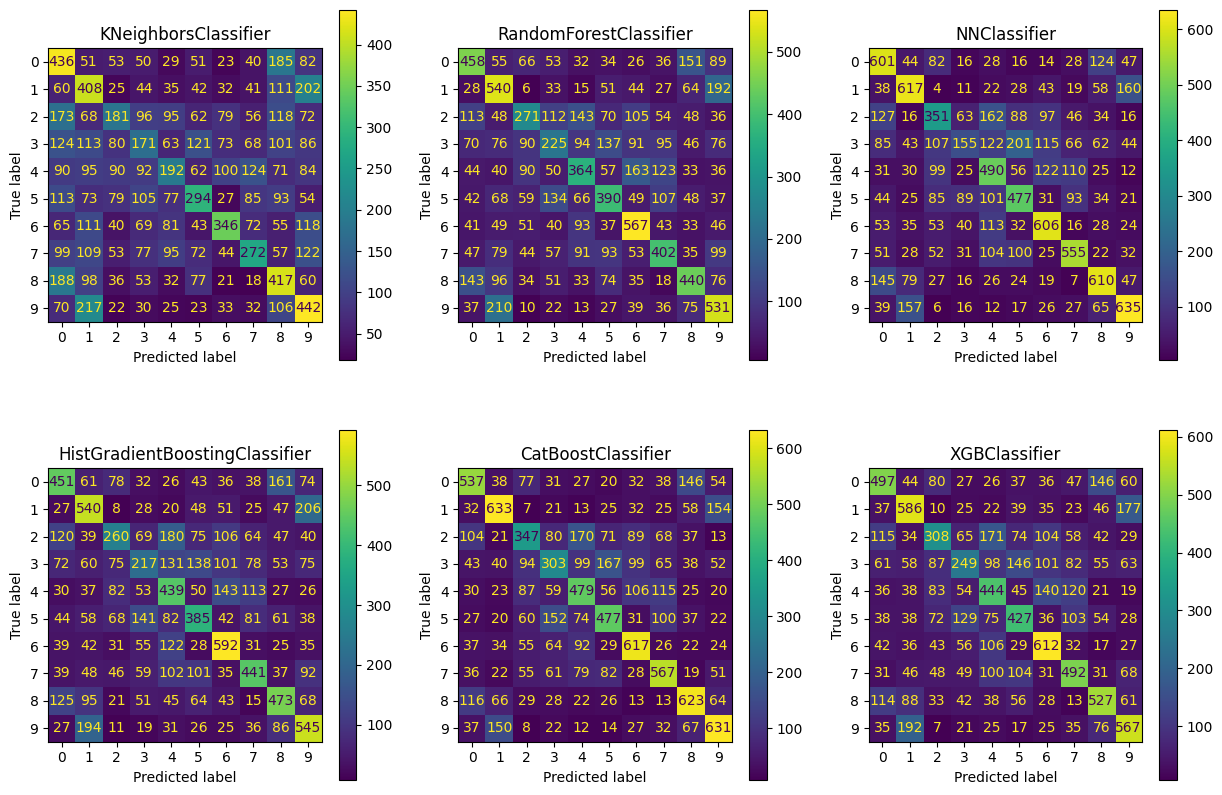

In [12]:
import cvtda.classification

cvtda.classification.classify(train_features, train_labels, test_features, test_labels)

In [13]:
import cvtda.utils

duplicates_remover = cvtda.utils.DuplicateFeaturesRemover()
train_features = duplicates_remover.fit_transform(train_features)
test_features = duplicates_remover.transform(test_features)

train_features.shape, test_features.shape

100%|██████████| 9594/9594 [00:16<00:00, 575.99it/s, partition_by=0, num_features=1, duplicates=346] 


Found 346 duplicates


((50000, 9594), (10000, 9594))

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
{'classifier': 'KNeighborsClassifier', 'Accuracy': 0.3153, 'TOP-2 Accuracy': 0.4917, 'TOP-3 Accuracy': 0.6202, 'TOP-4 Accuracy': 0.7121, 'TOP-5 Accuracy': 0.7886, 'TOP-6 Accuracy': 0.8486, 'TOP-7 Accuracy': 0.9005, 'TOP-8 Accuracy': 0.9409, 'TOP-9 Accuracy': 0.9746, 'AUC-ROC': 0.7508879555555557, 'Precision': 0.31426226335151125, 'Recall': 0.3153, 'F1-score': 0.30836957733414694}
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
{'classifier': 'RandomForestClassifier', 'Accuracy': 0.4169, 'TOP-2 Accuracy': 0.6121, 'TOP-3 Accuracy': 0.7175, 'TOP-4 Accuracy': 0.7934, 'TOP-5 Accuracy': 0.8545, 'TOP-6 Accuracy': 0.8992, 'TOP-7 Accuracy': 0.9335, 'TOP-8 Accuracy': 0.9611, 'TOP-9 Accuracy': 0.9836, 'AUC-ROC': 0.8216789555555557, 'Precision': 0.4112031672216946, 'Recall': 0.41690000000000005, 'F1-score': 0.4113902903963881}
Fitting <cvtda.classification.nn_classifier.NNClassifier object at 0x0000019FDC74DBD0>
Input to LazyLinear

100%|██████████| 25/25 [03:00<00:00,  7.23s/it, loss=9.75e+4, val_acc=0.516]


{'classifier': 'NNClassifier', 'Accuracy': 0.5156, 'TOP-2 Accuracy': 0.6993, 'TOP-3 Accuracy': 0.796, 'TOP-4 Accuracy': 0.8599, 'TOP-5 Accuracy': 0.9063, 'TOP-6 Accuracy': 0.938, 'TOP-7 Accuracy': 0.9597, 'TOP-8 Accuracy': 0.9779, 'TOP-9 Accuracy': 0.9908, 'AUC-ROC': 0.86019105, 'Precision': 0.5033113826164554, 'Recall': 0.5156, 'F1-score': 0.502148632147505}
Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
{'classifier': 'HistGradientBoostingClassifier', 'Accuracy': 0.4319, 'TOP-2 Accuracy': 0.6335, 'TOP-3 Accuracy': 0.7469, 'TOP-4 Accuracy': 0.8231, 'TOP-5 Accuracy': 0.8786, 'TOP-6 Accuracy': 0.9195, 'TOP-7 Accuracy': 0.9523, 'TOP-8 Accuracy': 0.9745, 'TOP-9 Accuracy': 0.9895, 'AUC-ROC': 0.8393774666666667, 'Precision': 0.42474039918943396, 'Recall': 0.4319, 'F1-score': 0.42462004294616096}
Fitting <catboost.core.CatBoostClassifier object at 0x0000019FDC74D630>
Learning rate set to 0.309284
0:	learn: 2.

,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.3153,0.4917,0.6202,0.7121,0.7886,0.8486,0.9005,0.9409,0.9746,0.750888,0.314262,0.3153,0.308370
1,RandomForestClassifier,0.4169,0.6121,0.7175,0.7934,0.8545,0.8992,0.9335,0.9611,0.9836,0.821679,0.411203,0.4169,0.411390
2,NNClassifier,0.5156,0.6993,0.7960,0.8599,0.9063,0.9380,0.9597,0.9779,0.9908,0.860191,0.503311,0.5156,0.502149
3,HistGradientBoostingClassifier,0.4319,0.6335,0.7469,0.8231,0.8786,0.9195,0.9523,0.9745,0.9895,0.839377,0.424740,0.4319,0.424620
4,CatBoostClassifier,0.5214,0.7204,0.8209,0.8837,0.9252,0.9531,0.9733,0.9866,0.9949,0.890542,0.515480,0.5214,0.517358
5,XGBClassifier,0.4709,0.6673,0.7711,0.8463,0.9009,0.9386,0.9636,0.9803,0.9933,0.860390,0.464397,0.4709,0.465439


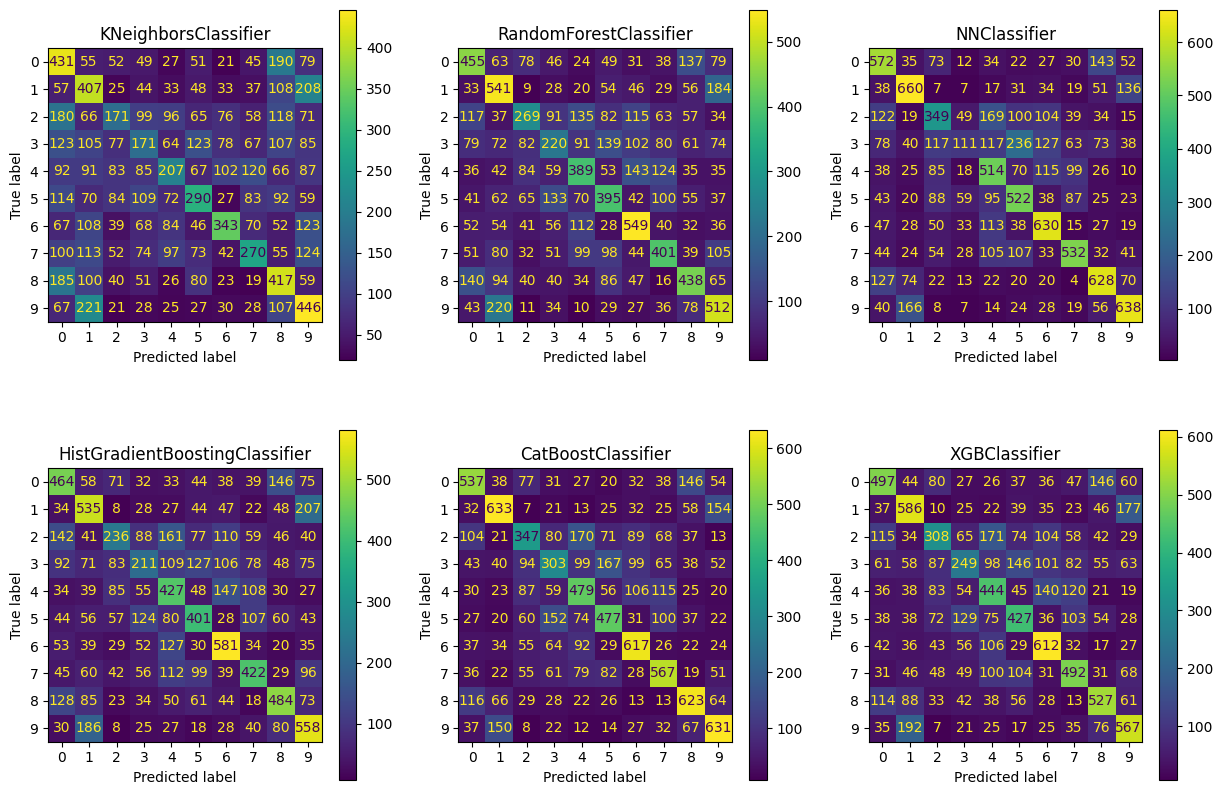

In [14]:
cvtda.classification.classify(train_features, train_labels, test_features, test_labels)

Fitting the information value feature selector


information values: 100%|██████████| 9594/9594 [01:33<00:00, 102.19it/s]

Fitting complete


<Axes: >

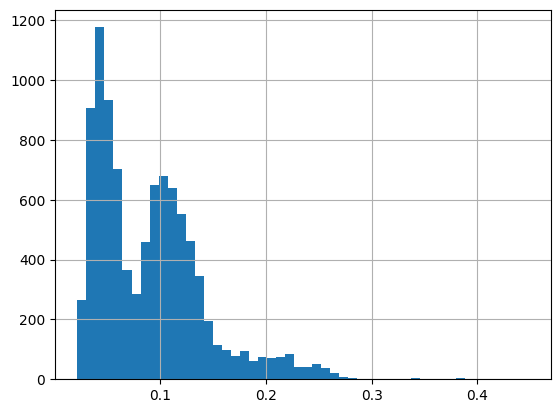

In [15]:
import cvtda.classification

feature_selector = cvtda.classification.InformationValueFeatureSelector(threshold = 0.05, bins = 50)
feature_selector.fit(train_features, train_labels)
feature_selector.hist()

In [16]:
train_features = feature_selector.transform(train_features)
test_features = feature_selector.transform(test_features)

train_features.shape, test_features.shape

((50000, 6893), (10000, 6893))

In [ ]:
cvtda.classification.classify(train_features, train_labels, test_features, test_labels)

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=50)


Fitting the correlations feature selector
Fitting complete


((50000, 10872), (10000, 10872))

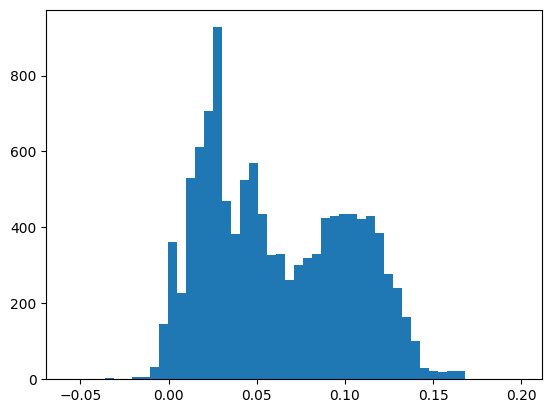

In [17]:
correlation_selector = cvtda.classification.CorrelationSelector(threshold = 0.01)

train_features = correlation_selector.fit_transform(train_features, train_labels)
test_features = correlation_selector.transform(test_features)

correlation_selector.hist()

train_features.shape, test_features.shape

Fitting KNeighborsClassifier(n_jobs=-1, n_neighbors=50)
{'classifier': 'KNeighborsClassifier', 'Accuracy': 0.346, 'TOP-2 Accuracy': 0.5321, 'TOP-3 Accuracy': 0.6459, 'TOP-4 Accuracy': 0.7363, 'TOP-5 Accuracy': 0.8063, 'TOP-6 Accuracy': 0.8678, 'TOP-7 Accuracy': 0.9139, 'TOP-8 Accuracy': 0.9486, 'TOP-9 Accuracy': 0.9793, 'AUC-ROC': 0.7737887888888887, 'Precision': 0.34444240512058755, 'Recall': 0.34600000000000003, 'F1-score': 0.3388181444958317}
Fitting RandomForestClassifier(n_jobs=-1, random_state=42)
{'classifier': 'RandomForestClassifier', 'Accuracy': 0.4283, 'TOP-2 Accuracy': 0.6168, 'TOP-3 Accuracy': 0.7247, 'TOP-4 Accuracy': 0.7992, 'TOP-5 Accuracy': 0.8551, 'TOP-6 Accuracy': 0.9005, 'TOP-7 Accuracy': 0.9361, 'TOP-8 Accuracy': 0.963, 'TOP-9 Accuracy': 0.9838, 'AUC-ROC': 0.8269249500000001, 'Precision': 0.42218733653867985, 'Recall': 0.42829999999999996, 'F1-score': 0.42220548856924334}
Fitting <cvtda.classification.nn_classifier.NNClassifier object at 0x0000019BA7263820>
Input t

100%|██████████| 25/25 [03:26<00:00,  8.28s/it, loss=9.65e+4, val_acc=0.527]


{'classifier': 'NNClassifier', 'Accuracy': 0.5267, 'TOP-2 Accuracy': 0.7183, 'TOP-3 Accuracy': 0.8113, 'TOP-4 Accuracy': 0.8698, 'TOP-5 Accuracy': 0.9139, 'TOP-6 Accuracy': 0.942, 'TOP-7 Accuracy': 0.9655, 'TOP-8 Accuracy': 0.9807, 'TOP-9 Accuracy': 0.992, 'AUC-ROC': 0.8703356777777779, 'Precision': 0.5148428661077391, 'Recall': 0.5267000000000001, 'F1-score': 0.515815500957445}
Fitting HistGradientBoostingClassifier(max_depth=4, max_features=0.1, max_iter=20,
                               random_state=42)
{'classifier': 'HistGradientBoostingClassifier', 'Accuracy': 0.4466, 'TOP-2 Accuracy': 0.6423, 'TOP-3 Accuracy': 0.7498, 'TOP-4 Accuracy': 0.8266, 'TOP-5 Accuracy': 0.8829, 'TOP-6 Accuracy': 0.9228, 'TOP-7 Accuracy': 0.9544, 'TOP-8 Accuracy': 0.9759, 'TOP-9 Accuracy': 0.9908, 'AUC-ROC': 0.8448263999999998, 'Precision': 0.4395652219798623, 'Recall': 0.44659999999999994, 'F1-score': 0.4386960339354705}
Fitting <catboost.core.CatBoostClassifier object at 0x0000019BA7261BD0>
Learning ra

,classifier,Accuracy,TOP-2 Accuracy,TOP-3 Accuracy,TOP-4 Accuracy,TOP-5 Accuracy,TOP-6 Accuracy,TOP-7 Accuracy,TOP-8 Accuracy,TOP-9 Accuracy,AUC-ROC,Precision,Recall,F1-score
0,KNeighborsClassifier,0.3460,0.5321,0.6459,0.7363,0.8063,0.8678,0.9139,0.9486,0.9793,0.773789,0.344442,0.3460,0.338818
1,RandomForestClassifier,0.4283,0.6168,0.7247,0.7992,0.8551,0.9005,0.9361,0.9630,0.9838,0.826925,0.422187,0.4283,0.422205
2,NNClassifier,0.5267,0.7183,0.8113,0.8698,0.9139,0.9420,0.9655,0.9807,0.9920,0.870336,0.514843,0.5267,0.515816
3,HistGradientBoostingClassifier,0.4466,0.6423,0.7498,0.8266,0.8829,0.9228,0.9544,0.9759,0.9908,0.844826,0.439565,0.4466,0.438696
4,CatBoostClassifier,0.5286,0.7235,0.8244,0.8854,0.9251,0.9529,0.9739,0.9874,0.9948,0.892642,0.523290,0.5286,0.524935
5,XGBClassifier,0.4829,0.6760,0.7814,0.8545,0.9041,0.9396,0.9629,0.9798,0.9939,0.865072,0.477046,0.4829,0.477770


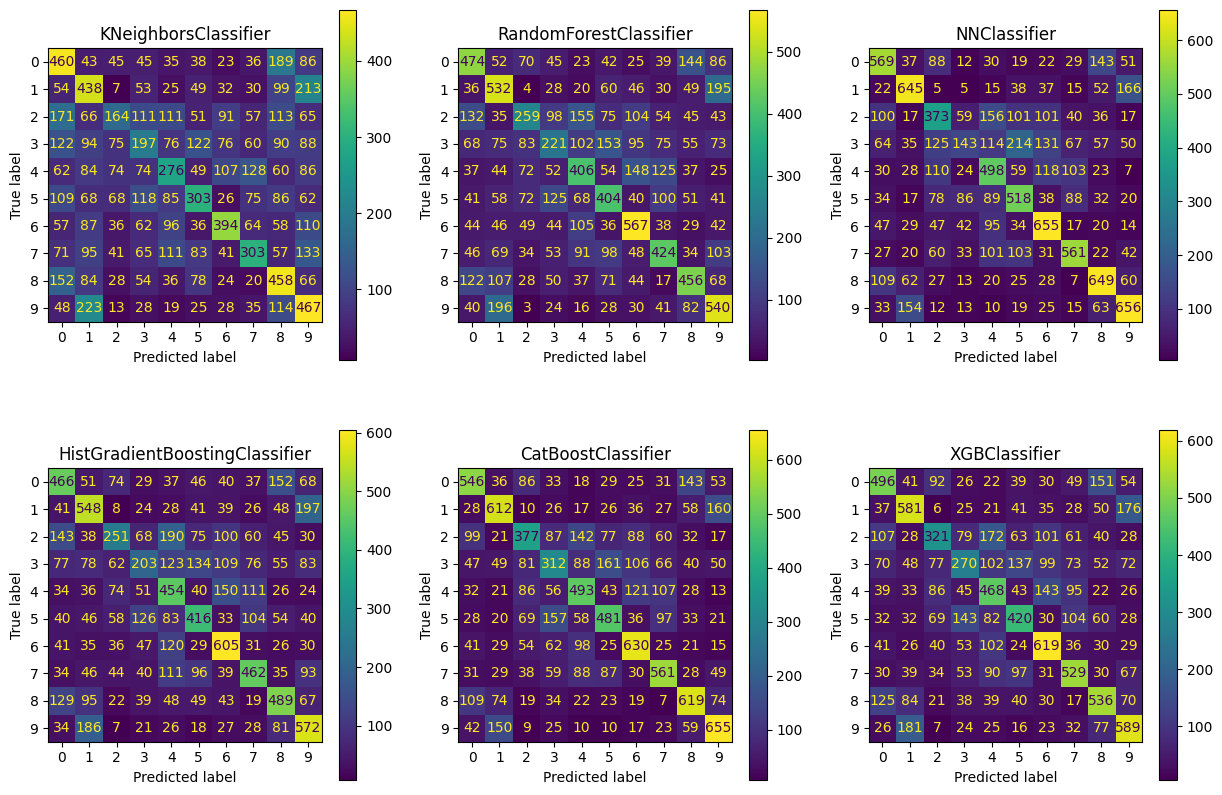

In [18]:
cvtda.classification.classify(train_features, train_labels, test_features, test_labels)